In [ ]:
pip install tensorflow numpy pandas matplotlib scikit-learn pillow

In [ ]:
# prepare_dataset.py
import os
import shutil
import random

def subsample_dataset(source_dir, target_dir, num_images_per_class=150):
    """
    Creates a new directory with a random subsample of images from each class.
    """
    # Create the target directory, erasing it if it already exists
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)
    os.makedirs(target_dir)

    print(f"Creating subsampled dataset at: {target_dir}")

    # Get the list of class directories (e.g., '0', '1', '2', ...)
    class_dirs = [d for d in os.listdir(source_dir) if os.path.isdir(os.path.join(source_dir, d))]

    for class_name in class_dirs:
        source_class_path = os.path.join(source_dir, class_name)
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path)

        # Get all image file names in the source class directory
        images = [f for f in os.listdir(source_class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Ensure we don't try to sample more images than available
        num_to_sample = min(num_images_per_class, len(images))

        # Randomly select the images
        selected_images = random.sample(images, num_to_sample)

        # Copy selected images to the new directory
        for image_name in selected_images:
            shutil.copy(os.path.join(source_class_path, image_name), target_class_path)
        
        print(f"Class '{class_name}': Copied {len(selected_images)} images.")

    print("\nSubsampling complete!")

# --- CONFIGURATION ---
# IMPORTANT: Update these paths to match your system
SOURCE_DATASET_PATH = "ITS Dataset" 
TARGET_DATASET_PATH = "ITS_Subsampled"
# ---------------------

if __name__ == '__main__':
    subsample_dataset(SOURCE_DATASET_PATH, TARGET_DATASET_PATH)

IMPORT

In [30]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
import shutil
import random


CONFIGURATION

In [31]:
# --- CONFIGURATION ---
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
EPOCHS = 15 # For the initial warm-up training

# Paths to the new split dataset
BASE_DATA_PATH = "split_dataset"
TRAIN_PATH = os.path.join(BASE_DATA_PATH, 'train')
VALIDATION_PATH = os.path.join(BASE_DATA_PATH, 'validation')
TEST_PATH = os.path.join(BASE_DATA_PATH, 'test')

DATA PREPARTION AND AUGMENTATION


In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Setting up data generators with standard rescaling for MobileNetV2...")

# The training generator uses standard rescaling and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,          # REVERTED: Back to simple rescaling
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

# The validation generator ONLY rescales the images
validation_datagen = ImageDataGenerator(rescale=1./255) # REVERTED: Back to simple rescaling

# Create the generators from their respective directories
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)
print(f"\nSuccessfully found {NUM_CLASSES} classes.")

Setting up data generators with standard rescaling for MobileNetV2...
Found 9743 images belonging to 58 classes.
Found 2088 images belonging to 58 classes.

Successfully found 58 classes.


BUILD THE MODEL

In [33]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow as tf

print("\nBuilding the model using MobileNetV2...")

# Load the MobileNetV2 base model, pre-trained on ImageNet
base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the layers of the base model for initial training
base_model.trainable = False

# Add our custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Reverted to 128 units, suitable for MobileNetV2
x = Dropout(0.5)(x) 
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with the safer initial learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print a summary of the model architecture
model.summary()


Building the model using MobileNetV2...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 171,450 (669.73 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

INITIAL TRAINING OF THE MODEL

In [34]:
print("\nStarting initial warm-up training...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    # class_weight=class_weights # Add this line
)

# Save the trained model
model.save("indian_traffic_sign_baseline.h5")
print("\nBaseline model saved as 'indian_traffic_sign_baseline.h5'")


Starting initial warm-up training...


c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 115s 357ms/step - accuracy: 0.2378 - loss: 3.1636 - val_accuracy: 0.6288 - val_loss: 1.3408
Epoch 2/15
  1/304 ━━━━━━━━━━━━━━━━━━━━ 1:15 248ms/step - accuracy: 0.6875 - loss: 1.1526

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


304/304 ━━━━━━━━━━━━━━━━━━━━ 15s 50ms/step - accuracy: 0.6875 - loss: 1.1526 - val_accuracy: 0.6293 - val_loss: 1.3385
Epoch 3/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 94s 309ms/step - accuracy: 0.5662 - loss: 1.4496 - val_accuracy: 0.6957 - val_loss: 1.0080
Epoch 4/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 13s 41ms/step - accuracy: 0.5938 - loss: 1.1523 - val_accuracy: 0.6933 - val_loss: 1.0059
Epoch 5/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 94s 310ms/step - accuracy: 0.6536 - loss: 1.1022 - val_accuracy: 0.7322 - val_loss: 0.8445
Epoch 6/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.5625 - loss: 1.2365 - val_accuracy: 0.7293 - val_loss: 0.8423
Epoch 7/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 110s 361ms/step - accuracy: 0.6874 - loss: 0.9475 - val_accuracy: 0.7385 - val_loss: 0.7849
Epoch 8/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - accuracy: 0.6250 - loss: 0.9847 - val_accuracy: 0.7423 - val_loss: 0.7812
Epoch 9/15
304/304 ━━━━━━━━━━━━━━━━━━━━ 112s 370ms/step - accuracy: 0.7264 - loss: 0.8406 - val_a


Baseline model saved as 'indian_traffic_sign_baseline.h5'


FINE TUNING THE MODEL

In [35]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("\n--- Starting Controlled Fine-Tuning ---")

# --- 1. Set up Cautious Unfreezing ---
base_model.trainable = True

# We will fine-tune from the last convolutional block onwards.
# For MobileNetV2, a good starting point is around layer 140.
fine_tune_at = 140 

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# --- 2. Re-compile the model with a very low learning rate ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # Start with a low learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("\nModel re-compiled for fine-tuning.")
model.summary()

# --- 3. Define Callbacks ---
# Stop training if `val_loss` doesn't improve for 3 consecutive epochs
# and restore the weights from the best performing epoch.
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3, 
    restore_best_weights=True,
    verbose=1
)

# Reduce the learning rate if `val_loss` plateaus for 2 epochs.
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=2, 
    min_lr=1e-7,
    verbose=1
)

# --- 4. Continue Training ---
fine_tune_epochs = 25 # Set a max number of epochs for fine-tuning
total_epochs = EPOCHS + fine_tune_epochs

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1], # Resume from where we left off
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping, lr_scheduler] # Activate both callbacks
)

# --- 5. Save the final fine-tuned model ---
model.save("indian_traffic_sign_finetuned.h5")
print("\nFine-tuned model saved as 'indian_traffic_sign_finetuned.h5'")


--- Starting Controlled Fine-Tuning ---

Model re-compiled for fine-tuning.


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,429,434 (9.27 MB)

 Trainable params: 1,211,450 (4.62 MB)

 Non-trainable params: 1,217,984 (4.65 MB)

Epoch 15/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 212s 673ms/step - accuracy: 0.5843 - loss: 1.4894 - val_accuracy: 0.7683 - val_loss: 0.6709 - learning_rate: 1.0000e-05
Epoch 16/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.7500 - loss: 1.0798 - val_accuracy: 0.7688 - val_loss: 0.6708 - learning_rate: 1.0000e-05
Epoch 17/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 196s 647ms/step - accuracy: 0.6712 - loss: 1.0202 - val_accuracy: 0.7721 - val_loss: 0.6545 - learning_rate: 1.0000e-05
Epoch 18/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 18s 58ms/step - accuracy: 0.7812 - loss: 0.7957 - val_accuracy: 0.7726 - val_loss: 0.6546 - learning_rate: 1.0000e-05
Epoch 19/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 84s 276ms/step - accuracy: 0.7107 - loss: 0.8799 - val_accuracy: 0.7784 - val_loss: 0.6332 - learning_rate: 1.0000e-05
Epoch 20/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 22s 73ms/step - accuracy: 0.9375 - loss: 0.4236 - val_accuracy: 0.7784 - val_loss: 0.6330 - learning_rate: 1.0000e-05
Epoch 21/40
304/304 ━━━━━━━━━━━━━━━━━━━━ 


Fine-tuned model saved as 'indian_traffic_sign_finetuned.h5'


PLOT THE TRAINING HISTORY

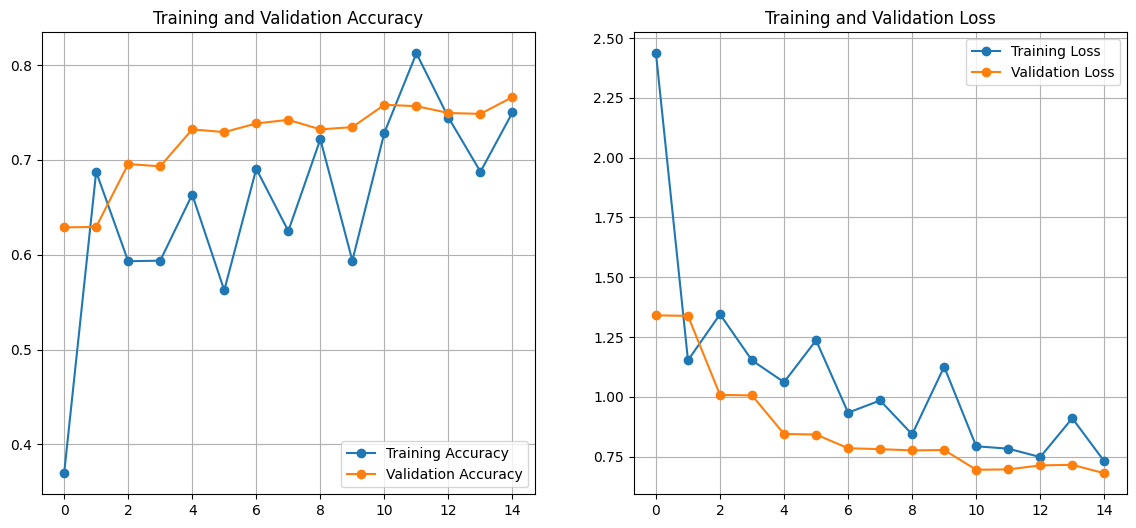

In [36]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.grid(True)
    
    plt.show()

plot_history(history)

PERFORMANCE MEASURE

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

print("Evaluating model performance on the validation set...")

# Get the true labels from the validation generator
y_true = validation_generator.classes

# Predict the classes for the validation set
validation_generator.reset()
Y_pred = model.predict(validation_generator, steps=int(np.ceil(validation_generator.samples / BATCH_SIZE)))
y_pred = np.argmax(Y_pred, axis=1)

# --- METRIC CALCULATIONS ---

# 1. Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"## Overall Accuracy: {accuracy:.4f}\n")

# 2. Precision, Recall (Sensitivity), F1-Score
# This report provides the main metrics per class and their averages.
print("## Classification Report (Precision, Recall/Sensitivity, F1-Score):")
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Specificity
# Specificity needs to be calculated on a per-class basis (one-vs-rest).
# Specificity = True Negatives / (True Negatives + False Positives)
cm = confusion_matrix(y_true, y_pred)
total_samples = np.sum(cm)
specificities = []

for i in range(NUM_CLASSES):
    # For class i
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = total_samples - (tp + fp + fn)
    
    # Calculate specificity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)

# Calculate the average specificity across all classes
avg_specificity = np.mean(specificities)
print("------------------------------------------------------")
print(f"## Average Specificity: {avg_specificity:.4f}")
print("------------------------------------------------------")

Evaluating model performance on the validation set...
66/66 ━━━━━━━━━━━━━━━━━━━━ 18s 251ms/step
## Overall Accuracy: 0.8190

## Classification Report (Precision, Recall/Sensitivity, F1-Score):
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.70      0.93      0.80        30
          10       1.00      0.90      0.95        30
          11       0.94      1.00      0.97        30
          12       0.94      0.97      0.95        30
          13       0.96      0.90      0.93        30
          14       0.96      0.83      0.89        30
          15       0.96      0.80      0.87        30
          16       0.77      0.57      0.65        30
          17       0.87      0.87      0.87        30
          18       0.93      0.87      0.90        30
          19       0.90      0.90      0.90        30
           2       0.57      0.13      0.22        30
          20       0.61      0.86      0.71       

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

FINAL EVALUATION ON TEST DATA

In [38]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

print("--- Final Evaluation on the Unseen Test Set ---")

# 1. Load the best saved model
# Make sure the filename matches the one you saved in the fine-tuning step
final_model = load_model("indian_traffic_sign_finetuned.h5")

# 2. Create a data generator for the test set
# IMPORTANT: No augmentation, just rescaling. Shuffle must be False.
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# 3. Evaluate the model to get loss and accuracy
print("\nCalculating Test Loss and Accuracy...")
test_loss, test_accuracy = final_model.evaluate(test_generator)
print(f"## Test Accuracy: {test_accuracy:.4f}")
print(f"## Test Loss: {test_loss:.4f}")

# 4. Generate a detailed classification report
print("\n--- Test Classification Report ---")

# Get true labels
y_true = test_generator.classes

# Predict probabilities
Y_pred_probs = final_model.predict(test_generator, steps=int(np.ceil(test_generator.samples / BATCH_SIZE)))
# Convert probabilities to class labels
y_pred = np.argmax(Y_pred_probs, axis=1)

# Get class names
class_names = list(train_generator.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=class_names))

# 5. Calculate Average Specificity for the test set
cm = confusion_matrix(y_true, y_pred)
total_samples = np.sum(cm)
specificities = []

for i in range(NUM_CLASSES):
    tp = cm[i, i]
    fp = np.sum(cm[:, i]) - tp
    fn = np.sum(cm[i, :]) - tp
    tn = total_samples - (tp + fp + fn)
    
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    specificities.append(specificity)

avg_specificity = np.mean(specificities)
print("------------------------------------------------------")
print(f"## Average Test Specificity: {avg_specificity:.4f}")
print("------------------------------------------------------")

--- Final Evaluation on the Unseen Test Set ---


Found 2140 images belonging to 58 classes.


c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Calculating Test Loss and Accuracy...
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 229ms/step - accuracy: 0.7883 - loss: 0.5954
## Test Accuracy: 0.8065
## Test Loss: 0.5154

--- Test Classification Report ---
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 247ms/step
              precision    recall  f1-score   support

           0       0.84      0.84      0.84        31
           1       0.84      0.84      0.84        31
          10       1.00      0.81      0.89        31
          11       0.91      0.97      0.94        31
          12       0.94      0.94      0.94        31
          13       0.93      0.90      0.92        31
          14       1.00      0.94      0.97        31
          15       0.93      0.87      0.90        31
          16       0.69      0.65      0.67        31
          17       0.77      0.77      0.77        31
          18       0.96      0.84      0.90        31
          19       0.85      0.94      0.89        31
           2       0.36      0.13      0.19        31
    

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

ADVERSARIAL ROBUSTNESS

In [39]:
pip install adversarial-robustness-toolbox

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: adversarial-robustness-toolbox in c:\users\vinay venkatachalam\appdata\local\programs\python\python311\lib\site-packages (1.20.1)




[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


GENERATE AND VISUALIZE ADVERSARIAL EXAMPLE

Model loaded successfully.
Loaded a batch of 32 test images.
Generating adversarial examples with FGSM...
Generation complete.
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step


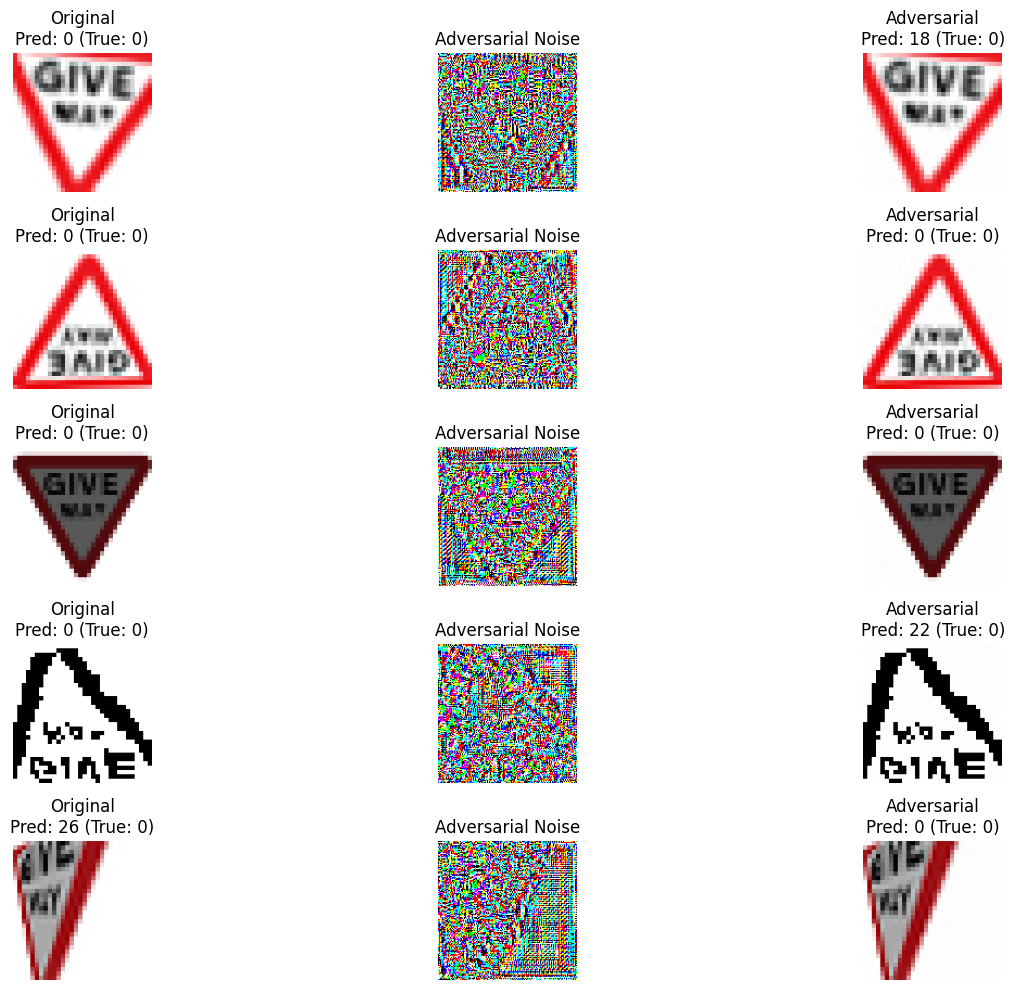

In [40]:
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Load your trained model ---
model = tf.keras.models.load_model("indian_traffic_sign_finetuned.h5")
print("Model loaded successfully.")

# --- 2. Create an ART Classifier ---
# The ART library needs a wrapper around your Keras model.
# We need to define the input shape and the number of classes.
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES, # NUM_CLASSES should be defined from your data loading cell
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), # IMG_HEIGHT/WIDTH from your config cell
    loss_object=model.loss # Use the model's own loss function
)

# --- 3. Set up the FGSM Attack ---
# Epsilon (eps) controls the "strength" of the attack.
# A smaller epsilon means less visible noise but a potentially weaker attack.
attack = FastGradientMethod(estimator=classifier, eps=0.01)

# --- 4. Get a batch of clean test images ---
# Make sure your test_generator is created and available from the previous cell
# We need to get the images AND their true labels
x_test_batch, y_test_batch = next(test_generator)
print(f"Loaded a batch of {x_test_batch.shape[0]} test images.")

# --- 5. Generate adversarial examples ---
print("Generating adversarial examples with FGSM...")
x_test_adv = attack.generate(x=x_test_batch)
print("Generation complete.")

# --- 6. Test the model on clean and adversarial images ---
preds_clean = model.predict(x_test_batch)
preds_adv = model.predict(x_test_adv)

# --- 7. Visualize the results ---
# Let's show the first 5 examples
n_examples = 5
plt.figure(figsize=(15, 10))

for i in range(n_examples):
    clean_label = np.argmax(preds_clean[i])
    adv_label = np.argmax(preds_adv[i])
    true_label = np.argmax(y_test_batch[i])

    # Original Image
    plt.subplot(n_examples, 3, i*3 + 1)
    plt.imshow(x_test_batch[i])
    plt.title(f"Original\nPred: {clean_label} (True: {true_label})")
    plt.axis('off')

    # The Noise (Adversarial Perturbation)
    noise = x_test_adv[i] - x_test_batch[i]
    # We "normalize" the noise to make it visible
    plt.subplot(n_examples, 3, i*3 + 2)
    plt.imshow((noise - noise.min()) / (noise.max() - noise.min()))
    plt.title("Adversarial Noise")
    plt.axis('off')
    
    # Adversarial Image
    plt.subplot(n_examples, 3, i*3 + 3)
    plt.imshow(x_test_adv[i])
    plt.title(f"Adversarial\nPred: {adv_label} (True: {true_label})")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [41]:
pip install ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


QUANTIFY THE ATTACK SUCCESS

In [42]:
import numpy as np
from tqdm.notebook import tqdm

print("Evaluating model accuracy on the full test set...")

# --- A. Accuracy on Clean Data ---
loss_clean, acc_clean = model.evaluate(test_generator, verbose=0)
print(f"Accuracy on CLEAN test data: {acc_clean * 100:.2f}%")

# --- B. Accuracy on Adversarial Data ---
y_true_all = []
y_pred_adv_all = []

# Loop through the entire test generator
for x_batch, y_batch in tqdm(test_generator, desc="Generating and Predicting"):
    # Stop if we've gone through the whole dataset
    if len(y_true_all) >= test_generator.samples:
        break
    
    # Generate adversarial examples for the current batch using the 'attack' object from the previous cell
    x_batch_adv = attack.generate(x=x_batch)
    
    # Get model predictions on the adversarial batch
    preds_adv = model.predict(x_batch_adv, verbose=0)
    y_pred_adv = np.argmax(preds_adv, axis=1)
    
    # Store the true labels and adversarial predictions
    y_true_all.extend(np.argmax(y_batch, axis=1))
    y_pred_adv_all.extend(y_pred_adv)

# Calculate the final accuracy on all adversarial examples
acc_adv = np.sum(np.array(y_pred_adv_all) == np.array(y_true_all)) / len(y_true_all)
print(f"Accuracy on ADVERSARIAL test data: {acc_adv * 100:.2f}%")

Evaluating model accuracy on the full test set...
Accuracy on CLEAN test data: 80.65%


Generating and Predicting:   0%|          | 0/67 [00:00<?, ?it/s]

Accuracy on ADVERSARIAL test data: 32.48%


IMPLEMENT THE DEFENSE

In [43]:
import numpy as np
from tqdm.notebook import tqdm

def extract_from_generator(generator):
    """Extracts all images and labels from a Keras generator into NumPy arrays."""
    x_list, y_list = [], []
    
    # Use tqdm for a progress bar
    for i in tqdm(range(len(generator)), desc=f"Extracting from {generator.directory.split('/')[-1]}"):
        x_batch, y_batch = generator[i]
        x_list.append(x_batch)
        y_list.append(y_batch)
        
    # Concatenate all batches into single arrays
    x_array = np.concatenate(x_list, axis=0)
    y_array = np.concatenate(y_list, axis=0)
    
    return x_array, y_array

print("Extracting training data into memory...")
x_train, y_train = extract_from_generator(train_generator)

print("\nExtracting validation data into memory...")
x_val, y_val = extract_from_generator(validation_generator)

print(f"\nData extraction complete.")
print(f"Training images shape: {x_train.shape}")
print(f"Validation images shape: {x_val.shape}")

Extracting training data into memory...


Extracting from split_dataset\train:   0%|          | 0/305 [00:00<?, ?it/s]


Extracting validation data into memory...


Extracting from split_dataset\validation:   0%|          | 0/66 [00:00<?, ?it/s]


Data extraction complete.
Training images shape: (9743, 128, 128, 3)
Validation images shape: (2088, 128, 128, 3)


In [44]:
from art.defences.trainer import AdversarialTrainer
from art.attacks.evasion import FastGradientMethod
import tensorflow as tf

# --- 1. Load your ORIGINAL clean model again ---
clean_model = tf.keras.models.load_model("indian_traffic_sign_finetuned.h5")

# --- THE FIX: Create a fresh optimizer instance ---
# Instead of using `clean_model.optimizer`, we create a new one.
# This ensures its internal state is perfectly synced with the loaded model.
# Use the same settings as your last successful fine-tuning run.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)

# --- 2. Create a new ART classifier with the NEW optimizer ---
robust_classifier = TensorFlowV2Classifier(
    model=clean_model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(), # Explicitly define the loss
    optimizer=optimizer # Pass the NEW optimizer to the wrapper
)

# --- 3. Create the Adversarial Trainer ---
attack = FastGradientMethod(estimator=robust_classifier, eps=0.01)
trainer = AdversarialTrainer(robust_classifier, attacks=attack, ratio=0.5)

# --- 4. Train the robust model using the NumPy arrays ---
print("\nStarting adversarial training...")
trainer.fit(
    x=x_train, 
    y=y_train, 
    nb_epochs=10, 
    validation_data=(x_val, y_val)
)

# --- 5. Save your new, robust model ---
robust_model = trainer.get_classifier().model
robust_model.save("indian_traffic_sign_robust.h5")
print("\nRobust model saved as 'indian_traffic_sign_robust.h5'")


Starting adversarial training...


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]


Robust model saved as 'indian_traffic_sign_robust.h5'


EVALUATE THE NEW ROBUST MODEL

In [45]:
import tensorflow as tf
import numpy as np
from tqdm.notebook import tqdm
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod

# --- 1. Load your NEW robust model ---
robust_model = tf.keras.models.load_model("indian_traffic_sign_robust.h5")

# --- 2. Evaluate on CLEAN data ---
loss_robust_clean, acc_robust_clean = robust_model.evaluate(test_generator, verbose=0)
print(f"ROBUST model accuracy on CLEAN test data: {acc_robust_clean * 100:.2f}%")

# --- 3. Evaluate on ADVERSARIAL data ---

# THE FIX: We must define the loss_object when creating the classifier
robust_art_classifier = TensorFlowV2Classifier(
    model=robust_model, 
    nb_classes=NUM_CLASSES, 
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy() # <-- This line was missing
)

# We create the attack targeted at the NEW robust model
# I've also updated eps to 0.01 to be consistent with our decision to use a more subtle attack.
attack_on_robust = FastGradientMethod(estimator=robust_art_classifier, eps=0.01)

y_true_all_robust = []
y_pred_adv_all_robust = []

for x_batch, y_batch in tqdm(test_generator, desc="Attacking Robust Model"):
    if len(y_true_all_robust) >= test_generator.samples:
        break
    
    x_batch_adv_robust = attack_on_robust.generate(x=x_batch)
    preds_adv_robust = robust_model.predict(x_batch_adv_robust, verbose=0)
    y_pred_adv_robust = np.argmax(preds_adv_robust, axis=1)
    
    y_true_all_robust.extend(np.argmax(y_batch, axis=1))
    y_pred_adv_all_robust.extend(y_pred_adv_robust)

acc_robust_adv = np.sum(np.array(y_pred_adv_all_robust) == np.array(y_true_all_robust)) / len(y_true_all_robust)
print(f"ROBUST model accuracy on ADVERSARIAL test data: {acc_robust_adv * 100:.2f}%")

ROBUST model accuracy on CLEAN test data: 82.62%


Attacking Robust Model:   0%|          | 0/67 [00:00<?, ?it/s]

ROBUST model accuracy on ADVERSARIAL test data: 40.65%


STICKER

ADVERSARIAL PATCH ATTACK SETUP

Setting up data generators...
Found 9743 images belonging to 58 classes.
Found 2088 images belonging to 58 classes.
Found 2140 images belonging to 58 classes.
✓ Generators created successfully
  Number of classes: 58
  Training samples: 9743
  Validation samples: 2088
  Test samples: 2140

------------------------------------------------------------
Loading the clean model...


✓ Clean model loaded successfully.

Creating ART classifier wrapper...
✓ Classifier wrapper created successfully.

Configuring adversarial patch attack...
  Patch size: 20% of image (26x26 pixels)
  Rotation range: ±22.5 degrees
  Scale range: 0.4 to 1.0
  Training iterations: 500
✓ Adversarial patch attack configured successfully.

GENERATING ADVERSARIAL PATCH
⚠️  This will take significant time (10-30 minutes)...
The algorithm will learn a universal 'sticker' that can fool your model.

Extracting training data from generator...


Loading training batches:   0%|          | 0/20 [00:00<?, ?it/s]

✓ Loaded 320 training images for patch generation.

Training the adversarial patch...
(You'll see progress bars as it optimizes the patch pixels)



Adversarial Patch TensorFlow v2:   0%|          | 0/500 [00:00<?, ?it/s]


✓ Patch generated successfully!

TESTING AND VISUALIZATION

Applying patch to TEST images...
Getting model predictions on test set...

------------------------------------------------------------
RESULTS ON TEST SET
------------------------------------------------------------
Test batch size: 16 images
Clean model accuracy: 13/16 (81.2%)
Patched model accuracy: 3/16 (18.8%)
Attack success rate: 76.9%
  (Successfully fooled 10 out of 13 correctly classified images)
------------------------------------------------------------

Generating visualizations...



C:\Users\Vinay Venkatachalam\AppData\Local\Temp\ipykernel_576\1961826844.py:200: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout()
C:\Users\Vinay Venkatachalam\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


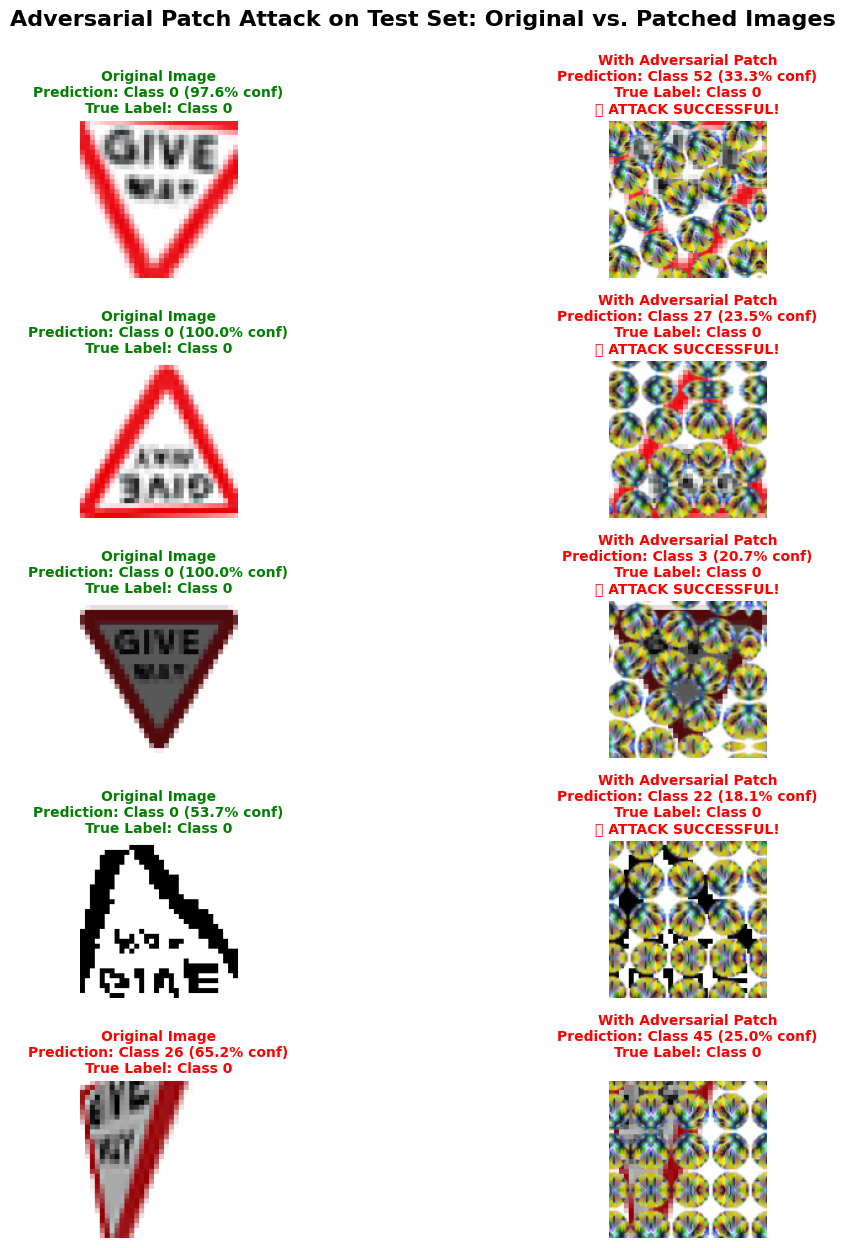

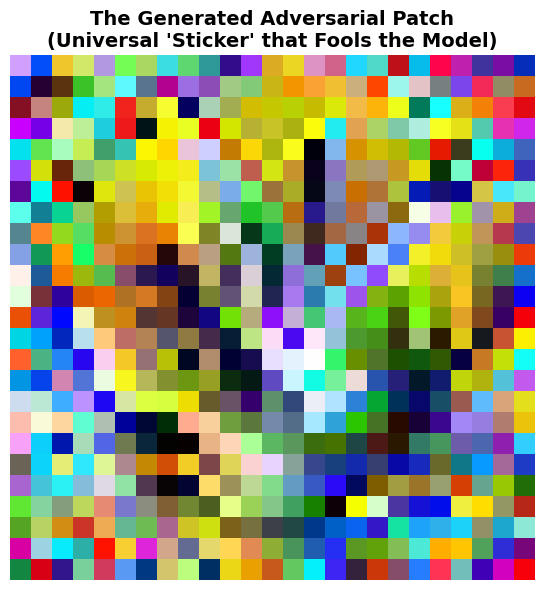


EVALUATING ON FULL TEST SET (Optional)
This will evaluate the patch attack on ALL test images...

Running full test set evaluation...


Evaluating batches:   0%|          | 0/134 [00:00<?, ?it/s]


------------------------------------------------------------
FULL TEST SET RESULTS
------------------------------------------------------------
Total test images: 2140
Clean model accuracy: 1726/2140 (80.65%)
Patched model accuracy: 58/2140 (2.71%)
Attack success rate: 96.64%
  (Successfully fooled 1668 out of 1726 correctly classified images)
------------------------------------------------------------

Saving the adversarial patch...
✓ Patch saved as 'adversarial_patch.npy'

✓ ADVERSARIAL PATCH ATTACK COMPLETED SUCCESSFULLY!

Patch details:
  Shape: (25, 25, 3)
  Min pixel value: 0.000
  Max pixel value: 1.000

This patch can now be placed on any traffic sign image to fool your model!
The patch has been saved and can be reused without regenerating it.

What this demonstrates:
  ✓ Your model is vulnerable to physical adversarial patches
  ✓ A small sticker can cause misclassification
  ✓ This is a more realistic attack than FGSM (digital noise)
  ✓ Next step: Train a robust model tha

In [8]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion.adversarial_patch.adversarial_patch_tensorflow import AdversarialPatchTensorFlowV2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# --- 0. Setup Paths and Parameters ---
TRAIN_PATH = "split_dataset/train"          # UPDATE THIS - folder with 58 subfolders
VALIDATION_PATH = "split_dataset/validation"  # UPDATE THIS - folder with 58 subfolders
TEST_PATH = "split_dataset/test"            # UPDATE THIS - folder with 58 subfolders

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16

print("="*60)
print("ADVERSARIAL PATCH ATTACK SETUP")
print("="*60)

# --- 1. Setup Data Generators ---
print("\nSetting up data generators...")

# Training generator - NO augmentation needed for patch generation
train_datagen = ImageDataGenerator(rescale=1./255)

# Validation generator
validation_datagen = ImageDataGenerator(rescale=1./255)

# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

NUM_CLASSES = len(train_generator.class_indices)

print(f"✓ Generators created successfully")
print(f"  Number of classes: {NUM_CLASSES}")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Test samples: {test_generator.samples}")

# --- 2. Load your trained CLEAN model ---
print("\n" + "-"*60)
print("Loading the clean model...")
model = tf.keras.models.load_model("indian_traffic_sign_finetuned.h5")
print("✓ Clean model loaded successfully.")

# --- 3. Create an ART Classifier Wrapper ---
print("\nCreating ART classifier wrapper...")
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0)
)
print("✓ Classifier wrapper created successfully.")

# --- 4. Define the Adversarial Patch Attack ---
print("\nConfiguring adversarial patch attack...")
print("  Patch size: 20% of image (26x26 pixels)")
print("  Rotation range: ±22.5 degrees")
print("  Scale range: 0.4 to 1.0")
print("  Training iterations: 500")

attack_patch = AdversarialPatchTensorFlowV2(
    classifier,
    rotation_max=22.5,
    scale_min=0.4,
    scale_max=1.0,
    learning_rate=0.01,
    max_iter=500,
    batch_size=16,
    patch_shape=(int(IMG_HEIGHT * 0.2), int(IMG_WIDTH * 0.2), 3)
)
print("✓ Adversarial patch attack configured successfully.")

# --- 5. Generate the Adversarial Patch ---
print("\n" + "="*60)
print("GENERATING ADVERSARIAL PATCH")
print("="*60)
print("⚠️  This will take significant time (10-30 minutes)...")
print("The algorithm will learn a universal 'sticker' that can fool your model.\n")

# Extract training data for patch generation
print("Extracting training data from generator...")
x_train_subset = []
y_train_subset = []
num_batches = 20  # 20 batches × 16 images = 320 training images

for i in tqdm(range(num_batches), desc="Loading training batches"):
    x_batch, y_batch = next(train_generator)
    x_train_subset.append(x_batch)
    y_train_subset.append(y_batch)

x_train_subset = np.concatenate(x_train_subset, axis=0)
y_train_subset = np.concatenate(y_train_subset, axis=0)

print(f"✓ Loaded {len(x_train_subset)} training images for patch generation.\n")

# Generate the patch (THIS IS THE SLOW PART)
print("Training the adversarial patch...")
print("(You'll see progress bars as it optimizes the patch pixels)\n")

patch, patch_mask = attack_patch.generate(x=x_train_subset, y=y_train_subset)

print("\n✓ Patch generated successfully!")

# --- 6. Apply and Visualize the Patch on TEST Set ---
print("\n" + "="*60)
print("TESTING AND VISUALIZATION")
print("="*60)

print("\nApplying patch to TEST images...")
x_test_batch, y_test_batch = next(test_generator)

# Apply the patch with 25% scale (so it covers 25% of the image area)
x_test_patched = attack_patch.apply_patch(x_test_batch, scale=0.25)

# Get predictions
print("Getting model predictions on test set...")
preds_clean = model.predict(x_test_batch, verbose=0)
preds_patched = model.predict(x_test_patched, verbose=0)

# Calculate attack success rate
clean_correct = np.sum(np.argmax(preds_clean, axis=1) == np.argmax(y_test_batch, axis=1))
patched_correct = np.sum(np.argmax(preds_patched, axis=1) == np.argmax(y_test_batch, axis=1))
attack_success = clean_correct - patched_correct

print("\n" + "-"*60)
print("RESULTS ON TEST SET")
print("-"*60)
print(f"Test batch size: {len(x_test_batch)} images")
print(f"Clean model accuracy: {clean_correct}/{len(x_test_batch)} ({100*clean_correct/len(x_test_batch):.1f}%)")
print(f"Patched model accuracy: {patched_correct}/{len(x_test_batch)} ({100*patched_correct/len(x_test_batch):.1f}%)")
if clean_correct > 0:
    print(f"Attack success rate: {100*attack_success/clean_correct:.1f}%")
    print(f"  (Successfully fooled {attack_success} out of {clean_correct} correctly classified images)")
print("-"*60)

# --- 7. Visualization ---
print("\nGenerating visualizations...\n")

# Side-by-side comparison
n_examples = min(5, len(x_test_batch))
plt.figure(figsize=(14, 2.5*n_examples))
plt.suptitle("Adversarial Patch Attack on Test Set: Original vs. Patched Images", 
             fontsize=16, fontweight='bold', y=0.995)

for i in range(n_examples):
    clean_pred = np.argmax(preds_clean[i])
    patched_pred = np.argmax(preds_patched[i])
    true_label = np.argmax(y_test_batch[i])
    
    clean_conf = np.max(preds_clean[i]) * 100
    patched_conf = np.max(preds_patched[i]) * 100
    
    # Original image
    plt.subplot(n_examples, 2, i*2 + 1)
    plt.imshow(x_test_batch[i])
    color_clean = 'green' if clean_pred == true_label else 'red'
    plt.title(f"Original Image\nPrediction: Class {clean_pred} ({clean_conf:.1f}% conf)\nTrue Label: Class {true_label}", 
              fontsize=10, color=color_clean, fontweight='bold')
    plt.axis('off')
    
    # Patched image
    plt.subplot(n_examples, 2, i*2 + 2)
    plt.imshow(np.clip(x_test_patched[i], 0, 1))
    color_patched = 'green' if patched_pred == true_label else 'red'
    attack_marker = "❌ ATTACK SUCCESSFUL!" if (clean_pred == true_label and patched_pred != true_label) else ""
    plt.title(f"With Adversarial Patch\nPrediction: Class {patched_pred} ({patched_conf:.1f}% conf)\nTrue Label: Class {true_label}\n{attack_marker}", 
              fontsize=10, color=color_patched, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.show()

# Visualize the patch itself
plt.figure(figsize=(6, 6))
plt.title("The Generated Adversarial Patch\n(Universal 'Sticker' that Fools the Model)", 
          fontsize=14, fontweight='bold')
plt.imshow(np.clip(patch, 0, 1))
plt.axis('off')
plt.tight_layout()
plt.show()

# --- 8. Optional: Evaluate on Full Test Set ---
print("\n" + "="*60)
print("EVALUATING ON FULL TEST SET (Optional)")
print("="*60)
print("This will evaluate the patch attack on ALL test images...")
user_input = input("Do you want to run full test set evaluation? (y/n): ")

if user_input.lower() == 'y':
    print("\nRunning full test set evaluation...")
    
    total_clean_correct = 0
    total_patched_correct = 0
    total_images = 0
    
    # Reset the test generator
    test_generator.reset()
    num_test_batches = len(test_generator)
    
    for batch_idx in tqdm(range(num_test_batches), desc="Evaluating batches"):
        x_batch, y_batch = next(test_generator)
        x_batch_patched = attack_patch.apply_patch(x_batch, scale=0.25)
        
        preds_clean_batch = model.predict(x_batch, verbose=0)
        preds_patched_batch = model.predict(x_batch_patched, verbose=0)
        
        clean_correct_batch = np.sum(np.argmax(preds_clean_batch, axis=1) == np.argmax(y_batch, axis=1))
        patched_correct_batch = np.sum(np.argmax(preds_patched_batch, axis=1) == np.argmax(y_batch, axis=1))
        
        total_clean_correct += clean_correct_batch
        total_patched_correct += patched_correct_batch
        total_images += len(x_batch)
    
    print("\n" + "-"*60)
    print("FULL TEST SET RESULTS")
    print("-"*60)
    print(f"Total test images: {total_images}")
    print(f"Clean model accuracy: {total_clean_correct}/{total_images} ({100*total_clean_correct/total_images:.2f}%)")
    print(f"Patched model accuracy: {total_patched_correct}/{total_images} ({100*total_patched_correct/total_images:.2f}%)")
    if total_clean_correct > 0:
        attack_success_full = total_clean_correct - total_patched_correct
        print(f"Attack success rate: {100*attack_success_full/total_clean_correct:.2f}%")
        print(f"  (Successfully fooled {attack_success_full} out of {total_clean_correct} correctly classified images)")
    print("-"*60)

# Save the patch for later use
print("\nSaving the adversarial patch...")
np.save('adversarial_patch.npy', patch)
print("✓ Patch saved as 'adversarial_patch.npy'")

print("\n" + "="*60)
print("✓ ADVERSARIAL PATCH ATTACK COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nPatch details:")
print(f"  Shape: {patch.shape}")
print(f"  Min pixel value: {patch.min():.3f}")
print(f"  Max pixel value: {patch.max():.3f}")
print(f"\nThis patch can now be placed on any traffic sign image to fool your model!")
print("The patch has been saved and can be reused without regenerating it.")
print("\nWhat this demonstrates:")
print("  ✓ Your model is vulnerable to physical adversarial patches")
print("  ✓ A small sticker can cause misclassification")
print("  ✓ This is a more realistic attack than FGSM (digital noise)")
print("  ✓ Next step: Train a robust model that can defend against this attack!")

ADVERSARIAL TRAINING: DEFENDING AGAINST PATCH ATTACKS

Loading the adversarial patch...
✓ Patch loaded: shape (25, 25, 3)

Setting up data generators...
Found 9743 images belonging to 58 classes.
Found 2088 images belonging to 58 classes.
Found 2140 images belonging to 58 classes.
✓ Generators created
  Training samples: 9743
  Validation samples: 2088
  Test samples: 2140

----------------------------------------------------------------------
Building a new model for adversarial training...
✓ Model built successfully
Total parameters: 2,600,826

Creating ART classifier wrapper...
✓ ART wrapper created

----------------------------------------------------------------------
Creating adversarial training generator...
  Training strategy: 50% clean images + 50% patched images

PHASE 1: TRAINING TOP LAYERS (Base Model Frozen)

Training for up to 15 epochs...
Steps per epoch: 608
Validation steps: 130

Epoch 1/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1502 - loss: 3.5766

c:\Users\Vinay Venkatachalam\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.60192, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 92s 146ms/step - accuracy: 0.1503 - loss: 3.5758 - val_accuracy: 0.6019 - val_loss: 1.4302 - learning_rate: 0.0010
Epoch 2/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.3241 - loss: 2.5112
Epoch 2: val_accuracy improved from 0.60192 to 0.62692, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.3241 - loss: 2.5111 - val_accuracy: 0.6269 - val_loss: 1.1452 - learning_rate: 0.0010
Epoch 3/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.3763 - loss: 2.2430
Epoch 3: val_accuracy improved from 0.62692 to 0.67500, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 152s 250ms/step - accuracy: 0.3764 - loss: 2.2430 - val_accuracy: 0.6750 - val_loss: 0.9718 - learning_rate: 0.0010
Epoch 4/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4066 - loss: 2.1178
Epoch 4: val_accuracy improved from 0.67500 to 0.69615, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 156s 257ms/step - accuracy: 0.4066 - loss: 2.1178 - val_accuracy: 0.6962 - val_loss: 0.8864 - learning_rate: 0.0010
Epoch 5/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.4277 - loss: 2.0325
Epoch 5: val_accuracy improved from 0.69615 to 0.73077, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 148s 244ms/step - accuracy: 0.4277 - loss: 2.0325 - val_accuracy: 0.7308 - val_loss: 0.8116 - learning_rate: 0.0010
Epoch 6/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.4395 - loss: 1.9682
Epoch 6: val_accuracy did not improve from 0.73077
608/608 ━━━━━━━━━━━━━━━━━━━━ 148s 244ms/step - accuracy: 0.4395 - loss: 1.9682 - val_accuracy: 0.7183 - val_loss: 0.8317 - learning_rate: 0.0010
Epoch 7/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.4451 - loss: 1.9232
Epoch 7: val_accuracy did not improve from 0.73077
608/608 ━━━━━━━━━━━━━━━━━━━━ 151s 248ms/step - accuracy: 0.4451 - loss: 1.9232 - val_accuracy: 0.7284 - val_loss: 0.7900 - learning_rate: 0.0010
Epoch 8/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.4664 - loss: 1.8610
Epoch 8: val_accuracy improved from 0.73077 to 0.74519, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 156s 257ms/step - accuracy: 0.4664 - loss: 1.8611 - val_accuracy: 0.7452 - val_loss: 0.7548 - learning_rate: 0.0010
Epoch 9/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - accuracy: 0.4631 - loss: 1.8508
Epoch 9: val_accuracy did not improve from 0.74519
608/608 ━━━━━━━━━━━━━━━━━━━━ 117s 193ms/step - accuracy: 0.4631 - loss: 1.8508 - val_accuracy: 0.7260 - val_loss: 0.8013 - learning_rate: 0.0010
Epoch 10/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.4589 - loss: 1.8641
Epoch 10: val_accuracy improved from 0.74519 to 0.74760, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 181s 298ms/step - accuracy: 0.4589 - loss: 1.8641 - val_accuracy: 0.7476 - val_loss: 0.7545 - learning_rate: 0.0010
Epoch 11/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.4714 - loss: 1.8042
Epoch 11: val_accuracy did not improve from 0.74760
608/608 ━━━━━━━━━━━━━━━━━━━━ 118s 195ms/step - accuracy: 0.4714 - loss: 1.8043 - val_accuracy: 0.7327 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 12/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.4723 - loss: 1.8142
Epoch 12: val_accuracy improved from 0.74760 to 0.76490, saving model to indian_traffic_sign_robust_phase1.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 78s 128ms/step - accuracy: 0.4723 - loss: 1.8142 - val_accuracy: 0.7649 - val_loss: 0.7098 - learning_rate: 0.0010
Epoch 13/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4894 - loss: 1.7703
Epoch 13: val_accuracy did not improve from 0.76490
608/608 ━━━━━━━━━━━━━━━━━━━━ 89s 146ms/step - accuracy: 0.4894 - loss: 1.7704 - val_accuracy: 0.7534 - val_loss: 0.7079 - learning_rate: 0.0010
Epoch 14/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4825 - loss: 1.7886
Epoch 14: val_accuracy did not improve from 0.76490
608/608 ━━━━━━━━━━━━━━━━━━━━ 90s 147ms/step - accuracy: 0.4825 - loss: 1.7886 - val_accuracy: 0.7486 - val_loss: 0.7316 - learning_rate: 0.0010
Epoch 15/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4912 - loss: 1.7454
Epoch 15: val_accuracy did not improve from 0.76490
608/608 ━━━━━━━━━━━━━━━━━━━━ 90s 147ms/step - accuracy: 0.4912 - loss: 1.7454 - val_accuracy: 0.7625 - val_loss: 0.6971 - learning_rate: 0.0010
R

608/608 ━━━━━━━━━━━━━━━━━━━━ 207s 312ms/step - accuracy: 0.3105 - loss: 3.1292 - val_accuracy: 0.6625 - val_loss: 1.2868 - learning_rate: 1.0000e-04
Epoch 2/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.4954 - loss: 1.7469
Epoch 2: val_accuracy did not improve from 0.66250
608/608 ━━━━━━━━━━━━━━━━━━━━ 197s 324ms/step - accuracy: 0.4954 - loss: 1.7467 - val_accuracy: 0.6284 - val_loss: 1.3544 - learning_rate: 1.0000e-04
Epoch 3/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.5672 - loss: 1.3902
Epoch 3: val_accuracy improved from 0.66250 to 0.76731, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 201s 330ms/step - accuracy: 0.5672 - loss: 1.3901 - val_accuracy: 0.7673 - val_loss: 0.6598 - learning_rate: 1.0000e-04
Epoch 4/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.6285 - loss: 1.1735
Epoch 4: val_accuracy did not improve from 0.76731
608/608 ━━━━━━━━━━━━━━━━━━━━ 189s 311ms/step - accuracy: 0.6285 - loss: 1.1735 - val_accuracy: 0.7471 - val_loss: 0.7751 - learning_rate: 1.0000e-04
Epoch 5/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.6657 - loss: 1.0485
Epoch 5: val_accuracy improved from 0.76731 to 0.85288, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 191s 314ms/step - accuracy: 0.6658 - loss: 1.0485 - val_accuracy: 0.8529 - val_loss: 0.3728 - learning_rate: 1.0000e-04
Epoch 6/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.7020 - loss: 0.8988
Epoch 6: val_accuracy improved from 0.85288 to 0.86538, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 220s 362ms/step - accuracy: 0.7020 - loss: 0.8988 - val_accuracy: 0.8654 - val_loss: 0.3689 - learning_rate: 1.0000e-04
Epoch 7/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.7315 - loss: 0.7799
Epoch 7: val_accuracy did not improve from 0.86538
608/608 ━━━━━━━━━━━━━━━━━━━━ 193s 318ms/step - accuracy: 0.7315 - loss: 0.7800 - val_accuracy: 0.8644 - val_loss: 0.3491 - learning_rate: 1.0000e-04
Epoch 8/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7469 - loss: 0.7421
Epoch 8: val_accuracy did not improve from 0.86538
608/608 ━━━━━━━━━━━━━━━━━━━━ 186s 306ms/step - accuracy: 0.7469 - loss: 0.7421 - val_accuracy: 0.8644 - val_loss: 0.3935 - learning_rate: 1.0000e-04
Epoch 9/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.7691 - loss: 0.6792
Epoch 9: val_accuracy improved from 0.86538 to 0.86635, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 193s 318ms/step - accuracy: 0.7691 - loss: 0.6792 - val_accuracy: 0.8663 - val_loss: 0.3705 - learning_rate: 1.0000e-04
Epoch 10/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.7811 - loss: 0.6522
Epoch 10: val_accuracy improved from 0.86635 to 0.87548, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 196s 323ms/step - accuracy: 0.7811 - loss: 0.6522 - val_accuracy: 0.8755 - val_loss: 0.3129 - learning_rate: 1.0000e-04
Epoch 11/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.7957 - loss: 0.5924
Epoch 11: val_accuracy improved from 0.87548 to 0.88125, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 192s 316ms/step - accuracy: 0.7957 - loss: 0.5925 - val_accuracy: 0.8813 - val_loss: 0.2769 - learning_rate: 1.0000e-04
Epoch 12/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.7958 - loss: 0.5680
Epoch 12: val_accuracy did not improve from 0.88125
608/608 ━━━━━━━━━━━━━━━━━━━━ 191s 314ms/step - accuracy: 0.7958 - loss: 0.5680 - val_accuracy: 0.8764 - val_loss: 0.3052 - learning_rate: 1.0000e-04
Epoch 13/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8021 - loss: 0.5405
Epoch 13: val_accuracy did not improve from 0.88125
608/608 ━━━━━━━━━━━━━━━━━━━━ 184s 303ms/step - accuracy: 0.8021 - loss: 0.5405 - val_accuracy: 0.8784 - val_loss: 0.2796 - learning_rate: 1.0000e-04
Epoch 14/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8166 - loss: 0.5249
Epoch 14: val_accuracy improved from 0.88125 to 0.88702, saving model to indian_traffic_sign_robust_patch.h5


608/608 ━━━━━━━━━━━━━━━━━━━━ 190s 313ms/step - accuracy: 0.8166 - loss: 0.5249 - val_accuracy: 0.8870 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 15/15
608/608 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.8196 - loss: 0.5364
Epoch 15: val_accuracy did not improve from 0.88702
608/608 ━━━━━━━━━━━━━━━━━━━━ 187s 307ms/step - accuracy: 0.8196 - loss: 0.5364 - val_accuracy: 0.8822 - val_loss: 0.2782 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 14.



✓ Phase 2 fine-tuning completed

✓ Final robust model saved as 'indian_traffic_sign_robust_patch_final.h5'

Generating training history plots...


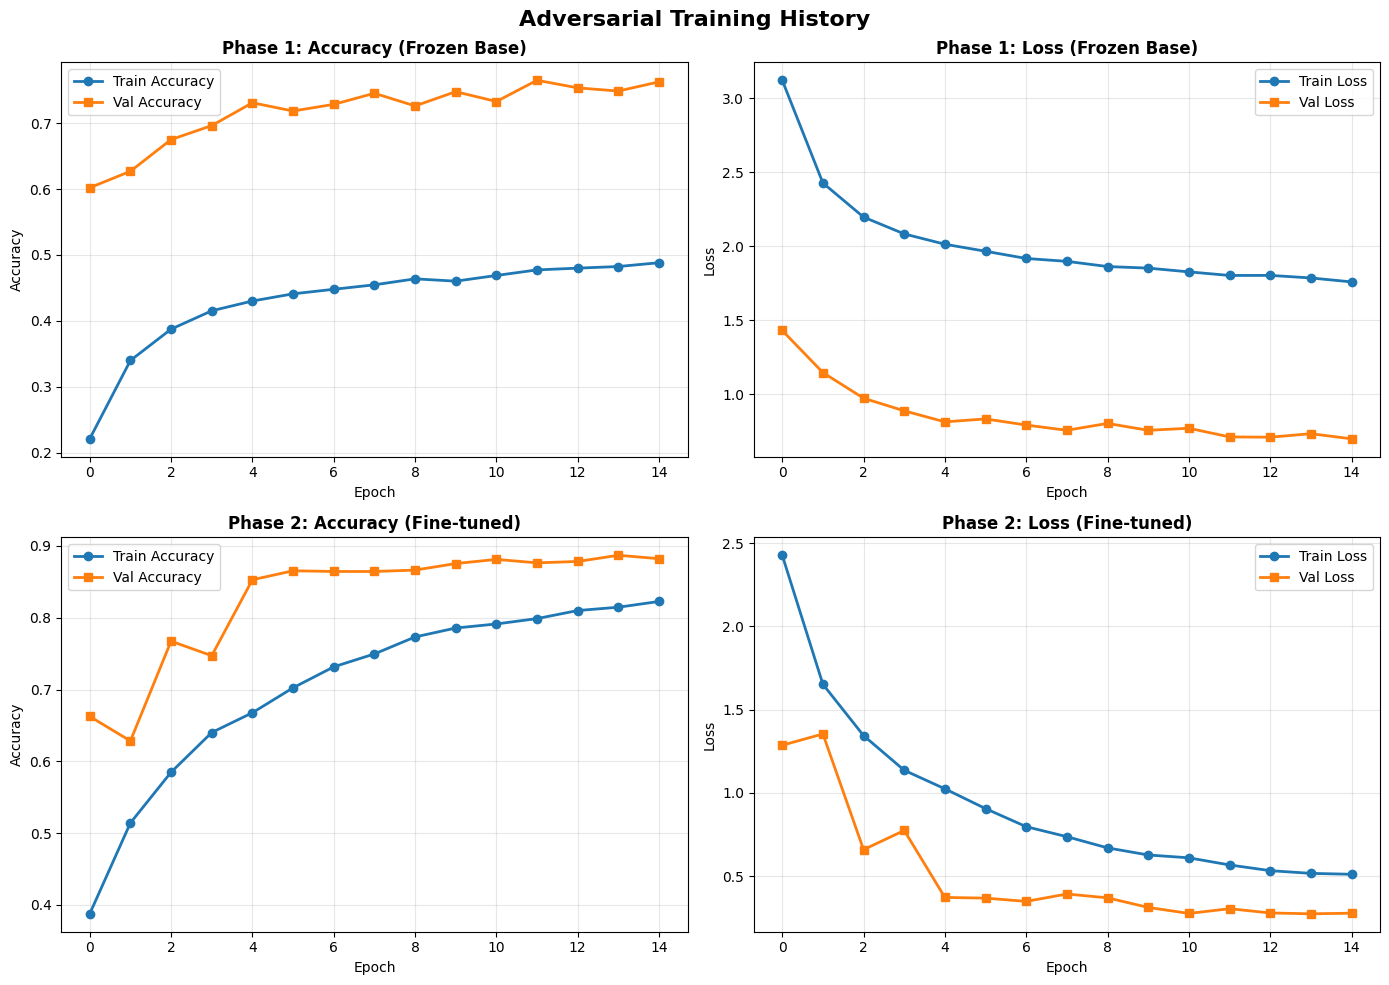


✓ ADVERSARIAL TRAINING COMPLETED!

Models saved:
  • indian_traffic_sign_robust_phase1.h5 (Phase 1 - frozen base)
  • indian_traffic_sign_robust_patch.h5 (Phase 2 - best checkpoint)
  • indian_traffic_sign_robust_patch_final.h5 (Phase 2 - final)

Next step: Evaluate the robust model against patch attacks!


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion.adversarial_patch.adversarial_patch_tensorflow import AdversarialPatchTensorFlowV2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("="*70)
print("ADVERSARIAL TRAINING: DEFENDING AGAINST PATCH ATTACKS")
print("="*70)

# --- 0. Setup Paths and Parameters ---
TRAIN_PATH = "split_dataset/train"          # UPDATE THIS - folder with 58 subfolders
VALIDATION_PATH = "split_dataset/validation"  # UPDATE THIS - folder with 58 subfolders
TEST_PATH = "split_dataset/test"            

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16
NUM_CLASSES = 58
EPOCHS = 15

# --- 1. Load the Pre-trained Adversarial Patch ---
print("\nLoading the adversarial patch...")
adversarial_patch = np.load('adversarial_patch.npy')
print(f"✓ Patch loaded: shape {adversarial_patch.shape}")

# --- 2. Setup Data Generators ---
print("\nSetting up data generators...")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✓ Generators created")
print(f"  Training samples: {train_generator.samples}")
print(f"  Validation samples: {validation_generator.samples}")
print(f"  Test samples: {test_generator.samples}")

# --- 3. Build a New Model (Starting Fresh) ---
print("\n" + "-"*70)
print("Building a new model for adversarial training...")

base_model = MobileNetV2(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model initially
base_model.trainable = False

# Add custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("✓ Model built successfully")
print(f"Total parameters: {model.count_params():,}")

# --- 4. Create ART Classifier Wrapper ---
print("\nCreating ART classifier wrapper...")
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0)
)

# Create patch attack object for applying patches during training
attack_patch = AdversarialPatchTensorFlowV2(
    classifier,
    rotation_max=22.5,
    scale_min=0.4,
    scale_max=1.0,
    learning_rate=0.01,
    max_iter=1,
    batch_size=16,
    patch_shape=adversarial_patch.shape
)

print("✓ ART wrapper created")

# --- 5. Create Adversarial Training Generator Function ---
def create_adversarial_generator(base_generator, patch, attack_obj, patch_ratio=0.5):
    """
    Generator function that yields mixed batches of clean and patched images.
    """
    while True:
        # Get a batch of clean images
        x_clean, y_clean = next(base_generator)
        
        # Determine how many images to patch in this batch
        batch_size = len(x_clean)
        num_to_patch = int(batch_size * patch_ratio)
        
        if num_to_patch > 0:
            # Apply patches to a subset of the batch
            indices_to_patch = np.random.choice(batch_size, num_to_patch, replace=False)
            
            # Create a copy to avoid modifying the original
            x_mixed = x_clean.copy()
            
            # Apply patches to selected images with random scale
            for idx in indices_to_patch:
                single_image = x_clean[idx:idx+1]
                scale = np.random.uniform(0.15, 0.35)  # Random patch size
                try:
                    patched_image = attack_obj.apply_patch(single_image, scale=scale)
                    x_mixed[idx] = patched_image[0]
                except:
                    # If patch application fails, keep the clean image
                    pass
            
            yield x_mixed, y_clean
        else:
            yield x_clean, y_clean

# Create adversarial training generator
print("\n" + "-"*70)
print("Creating adversarial training generator...")
print("  Training strategy: 50% clean images + 50% patched images")

# --- 6. Phase 1: Train with Frozen Base ---
print("\n" + "="*70)
print("PHASE 1: TRAINING TOP LAYERS (Base Model Frozen)")
print("="*70)

callbacks_phase1 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1),
    ModelCheckpoint('indian_traffic_sign_robust_phase1.h5', 
                    monitor='val_accuracy', 
                    save_best_only=True, 
                    verbose=1)
]

steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Create the generator for Phase 1
adv_train_gen_phase1 = create_adversarial_generator(
    train_generator, 
    adversarial_patch, 
    attack_patch,
    patch_ratio=0.5
)

print(f"\nTraining for up to {EPOCHS} epochs...")
print(f"Steps per epoch: {steps_per_epoch}")
print(f"Validation steps: {validation_steps}\n")

history_phase1 = model.fit(
    adv_train_gen_phase1,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_phase1,
    verbose=1
)

print("\n✓ Phase 1 training completed")

# --- 7. Phase 2: Fine-tune Entire Model ---
print("\n" + "="*70)
print("PHASE 2: FINE-TUNING ENTIRE MODEL")
print("="*70)

# Unfreeze the base model
base_model.trainable = True

# Recompile with lower learning rate
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"✓ Model unfrozen. Total trainable parameters: {model.count_params():,}")

# Update the classifier with the new model
classifier = TensorFlowV2Classifier(
    model=model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0)
)

# Recreate attack object with updated classifier
attack_patch = AdversarialPatchTensorFlowV2(
    classifier,
    rotation_max=22.5,
    scale_min=0.4,
    scale_max=1.0,
    learning_rate=0.01,
    max_iter=1,
    batch_size=16,
    patch_shape=adversarial_patch.shape
)

# Reset train generator and create new adversarial generator for Phase 2
train_generator.reset()
adv_train_gen_phase2 = create_adversarial_generator(
    train_generator, 
    adversarial_patch, 
    attack_patch,
    patch_ratio=0.5
)

callbacks_phase2 = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-8, verbose=1),
    ModelCheckpoint('indian_traffic_sign_robust_patch.h5', 
                    monitor='val_accuracy', 
                    save_best_only=True, 
                    verbose=1)
]

print(f"\nFine-tuning for up to {EPOCHS} epochs...\n")

history_phase2 = model.fit(
    adv_train_gen_phase2,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_phase2,
    verbose=1
)

print("\n✓ Phase 2 fine-tuning completed")

# --- 8. Save Final Model ---
model.save('indian_traffic_sign_robust_patch_final.h5')
print("\n✓ Final robust model saved as 'indian_traffic_sign_robust_patch_final.h5'")

# --- 9. Visualize Training History ---
print("\nGenerating training history plots...")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Adversarial Training History', fontsize=16, fontweight='bold')

# Phase 1 - Accuracy
axes[0, 0].plot(history_phase1.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[0, 0].plot(history_phase1.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[0, 0].set_title('Phase 1: Accuracy (Frozen Base)', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Phase 1 - Loss
axes[0, 1].plot(history_phase1.history['loss'], label='Train Loss', linewidth=2, marker='o')
axes[0, 1].plot(history_phase1.history['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[0, 1].set_title('Phase 1: Loss (Frozen Base)', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Phase 2 - Accuracy
axes[1, 0].plot(history_phase2.history['accuracy'], label='Train Accuracy', linewidth=2, marker='o')
axes[1, 0].plot(history_phase2.history['val_accuracy'], label='Val Accuracy', linewidth=2, marker='s')
axes[1, 0].set_title('Phase 2: Accuracy (Fine-tuned)', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Phase 2 - Loss
axes[1, 1].plot(history_phase2.history['loss'], label='Train Loss', linewidth=2, marker='o')
axes[1, 1].plot(history_phase2.history['val_loss'], label='Val Loss', linewidth=2, marker='s')
axes[1, 1].set_title('Phase 2: Loss (Fine-tuned)', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✓ ADVERSARIAL TRAINING COMPLETED!")
print("="*70)
print("\nModels saved:")
print("  • indian_traffic_sign_robust_phase1.h5 (Phase 1 - frozen base)")
print("  • indian_traffic_sign_robust_patch.h5 (Phase 2 - best checkpoint)")
print("  • indian_traffic_sign_robust_patch_final.h5 (Phase 2 - final)")
print("\nNext step: Evaluate the robust model against patch attacks!")

EVALUATING ROBUST MODEL AGAINST PATCH ATTACKS

Loading models...
  Loading clean (vulnerable) model...


  ✓ Clean model loaded
  Loading robust model...


  ✓ Robust model loaded

Loading adversarial patch...
✓ Patch loaded: shape (25, 25, 3)

Setting up test data generator...
Found 2140 images belonging to 58 classes.
✓ Test generator created
  Test samples: 2140

Creating ART classifier wrappers...
✓ ART wrappers created

RUNNING COMPREHENSIVE EVALUATION

Evaluating on 2140 test images...
This will take a few minutes...



Evaluating batches:   0%|          | 0/134 [00:00<?, ?it/s]


EVALUATION RESULTS

Total test images evaluated: 2140

----------------------------------------------------------------------
CLEAN (VULNERABLE) MODEL:
----------------------------------------------------------------------
  Accuracy on clean images:   1726/2140 (80.65%)
  Accuracy on patched images: 53/2140 (2.48%)
  Attack success rate:        96.93%
  → Model is VULNERABLE to patch attacks

----------------------------------------------------------------------
ROBUST (ADVERSARIALLY TRAINED) MODEL:
----------------------------------------------------------------------
  Accuracy on clean images:   1895/2140 (88.55%)
  Accuracy on patched images: 1746/2140 (81.59%)
  Attack success rate:        7.86%
  → Model is MORE ROBUST to patch attacks

----------------------------------------------------------------------
DEFENSE EFFECTIVENESS:
----------------------------------------------------------------------
  Improvement on patched images: +79.11%
  Reduction in attack success:   -89.07

C:\Users\Vinay Venkatachalam\AppData\Local\Temp\ipykernel_5228\3706037294.py:249: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models, fontweight='bold')


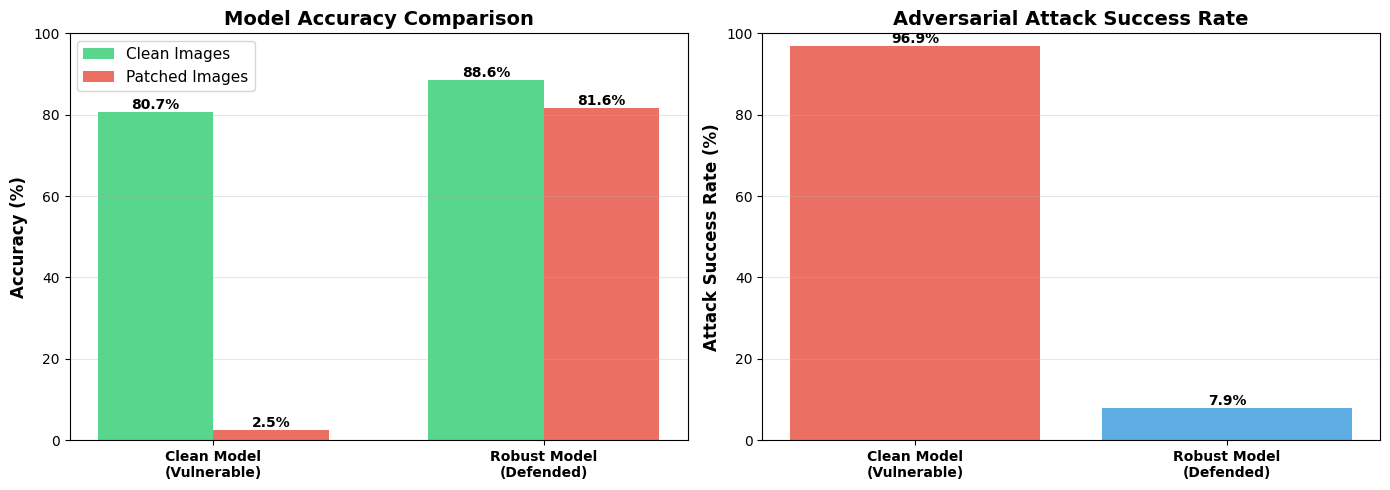

Generating sample prediction comparisons...



C:\Users\Vinay Venkatachalam\AppData\Local\Temp\ipykernel_5228\3706037294.py:321: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.97])
C:\Users\Vinay Venkatachalam\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


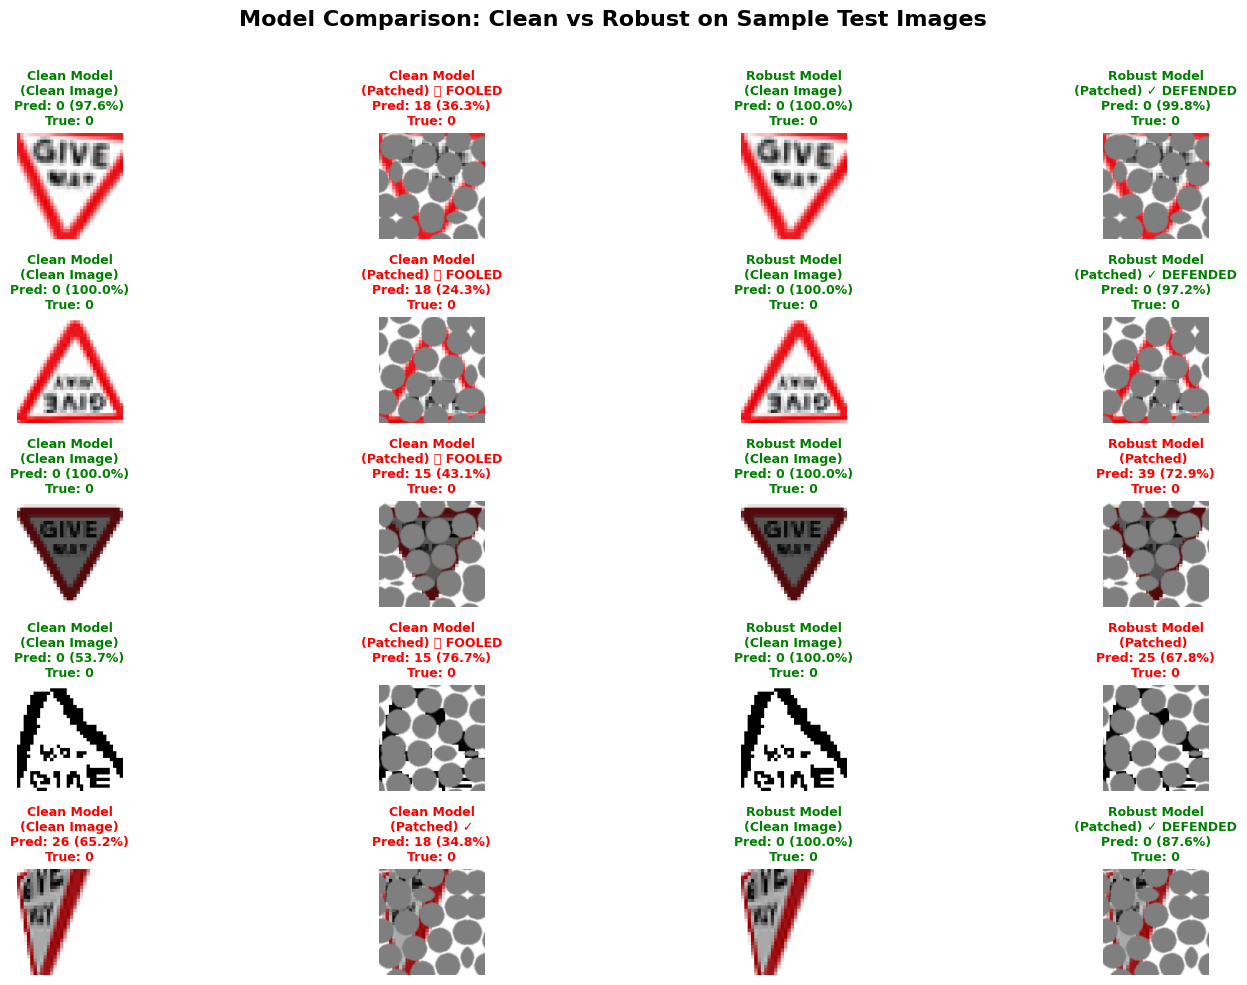


SUMMARY REPORT

📊 Key Findings:
  1. Clean model drops from 80.7% to 2.5% under attack
  2. Robust model maintains 81.6% accuracy under attack
  3. Defense provides +79.1% improvement on patched images
  4. Attack success reduced from 96.9% to 7.9%

🎯 Conclusions:
  ✓ Adversarial training successfully defended against patch attacks!
  ✓ The robust model is significantly more secure for deployment.

📁 Models Available:
  • indian_traffic_sign_finetuned.h5 (Clean/Vulnerable)
  • indian_traffic_sign_robust_patch_final.h5 (Robust/Defended)

✓ EVALUATION COMPLETED!


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion.adversarial_patch.adversarial_patch_tensorflow import AdversarialPatchTensorFlowV2
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

print("="*70)
print("EVALUATING ROBUST MODEL AGAINST PATCH ATTACKS")
print("="*70)

# --- 0. Setup Paths and Parameters ---
TEST_PATH = "split_dataset/test"  # UPDATE THIS

IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 16
NUM_CLASSES = 58

# --- 1. Load Models ---
print("\nLoading models...")
print("  Loading clean (vulnerable) model...")
clean_model = tf.keras.models.load_model("indian_traffic_sign_finetuned.h5")
print("  ✓ Clean model loaded")

print("  Loading robust model...")
robust_model = tf.keras.models.load_model("indian_traffic_sign_robust_patch_final.h5")
print("  ✓ Robust model loaded")

# --- 2. Load Adversarial Patch ---
print("\nLoading adversarial patch...")
adversarial_patch = np.load('adversarial_patch.npy')
print(f"✓ Patch loaded: shape {adversarial_patch.shape}")

# --- 3. Setup Test Generator ---
print("\nSetting up test data generator...")
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"✓ Test generator created")
print(f"  Test samples: {test_generator.samples}")

# --- 4. Create ART Wrappers for Both Models ---
print("\nCreating ART classifier wrappers...")

# Clean model wrapper
clean_classifier = TensorFlowV2Classifier(
    model=clean_model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0)
)

# Robust model wrapper
robust_classifier = TensorFlowV2Classifier(
    model=robust_model,
    nb_classes=NUM_CLASSES,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    loss_object=tf.keras.losses.CategoricalCrossentropy(),
    clip_values=(0.0, 1.0)
)

# Create patch attack objects
clean_attack = AdversarialPatchTensorFlowV2(
    clean_classifier,
    rotation_max=22.5,
    scale_min=0.4,
    scale_max=1.0,
    learning_rate=0.01,
    max_iter=1,
    batch_size=16,
    patch_shape=adversarial_patch.shape
)

robust_attack = AdversarialPatchTensorFlowV2(
    robust_classifier,
    rotation_max=22.5,
    scale_min=0.4,
    scale_max=1.0,
    learning_rate=0.01,
    max_iter=1,
    batch_size=16,
    patch_shape=adversarial_patch.shape
)

print("✓ ART wrappers created")

# --- 5. Comprehensive Evaluation ---
print("\n" + "="*70)
print("RUNNING COMPREHENSIVE EVALUATION")
print("="*70)

# Initialize counters
clean_model_clean_correct = 0
clean_model_patched_correct = 0
robust_model_clean_correct = 0
robust_model_patched_correct = 0
total_images = 0

# Storage for visualization
sample_clean_images = []
sample_patched_images = []
sample_labels = []
sample_clean_preds_clean = []
sample_clean_preds_patched = []
sample_robust_preds_clean = []
sample_robust_preds_patched = []

num_batches = len(test_generator)
test_generator.reset()

print(f"\nEvaluating on {test_generator.samples} test images...")
print("This will take a few minutes...\n")

for batch_idx in tqdm(range(num_batches), desc="Evaluating batches"):
    # Get batch
    x_batch, y_batch = next(test_generator)
    
    # Apply patch
    x_batch_patched = clean_attack.apply_patch(x_batch, scale=0.25)
    
    # Get predictions from both models on clean images
    clean_preds_on_clean = clean_model.predict(x_batch, verbose=0)
    robust_preds_on_clean = robust_model.predict(x_batch, verbose=0)
    
    # Get predictions from both models on patched images
    clean_preds_on_patched = clean_model.predict(x_batch_patched, verbose=0)
    robust_preds_on_patched = robust_model.predict(x_batch_patched, verbose=0)
    
    # Calculate correct predictions
    true_labels = np.argmax(y_batch, axis=1)
    
    clean_model_clean_correct += np.sum(np.argmax(clean_preds_on_clean, axis=1) == true_labels)
    clean_model_patched_correct += np.sum(np.argmax(clean_preds_on_patched, axis=1) == true_labels)
    robust_model_clean_correct += np.sum(np.argmax(robust_preds_on_clean, axis=1) == true_labels)
    robust_model_patched_correct += np.sum(np.argmax(robust_preds_on_patched, axis=1) == true_labels)
    
    total_images += len(x_batch)
    
    # Store first batch for visualization
    if batch_idx == 0:
        sample_clean_images = x_batch[:5]
        sample_patched_images = x_batch_patched[:5]
        sample_labels = y_batch[:5]
        sample_clean_preds_clean = clean_preds_on_clean[:5]
        sample_clean_preds_patched = clean_preds_on_patched[:5]
        sample_robust_preds_clean = robust_preds_on_clean[:5]
        sample_robust_preds_patched = robust_preds_on_patched[:5]

# --- 6. Calculate Metrics ---
print("\n" + "="*70)
print("EVALUATION RESULTS")
print("="*70)

clean_model_clean_acc = 100 * clean_model_clean_correct / total_images
clean_model_patched_acc = 100 * clean_model_patched_correct / total_images
robust_model_clean_acc = 100 * robust_model_clean_correct / total_images
robust_model_patched_acc = 100 * robust_model_patched_correct / total_images

# Attack success rates
clean_model_attack_success = 100 * (clean_model_clean_correct - clean_model_patched_correct) / clean_model_clean_correct if clean_model_clean_correct > 0 else 0
robust_model_attack_success = 100 * (robust_model_clean_correct - robust_model_patched_correct) / robust_model_clean_correct if robust_model_clean_correct > 0 else 0

# Defense effectiveness
defense_improvement = robust_model_patched_acc - clean_model_patched_acc

print(f"\nTotal test images evaluated: {total_images}")
print("\n" + "-"*70)
print("CLEAN (VULNERABLE) MODEL:")
print("-"*70)
print(f"  Accuracy on clean images:   {clean_model_clean_correct}/{total_images} ({clean_model_clean_acc:.2f}%)")
print(f"  Accuracy on patched images: {clean_model_patched_correct}/{total_images} ({clean_model_patched_acc:.2f}%)")
print(f"  Attack success rate:        {clean_model_attack_success:.2f}%")
print(f"  → Model is VULNERABLE to patch attacks")

print("\n" + "-"*70)
print("ROBUST (ADVERSARIALLY TRAINED) MODEL:")
print("-"*70)
print(f"  Accuracy on clean images:   {robust_model_clean_correct}/{total_images} ({robust_model_clean_acc:.2f}%)")
print(f"  Accuracy on patched images: {robust_model_patched_correct}/{total_images} ({robust_model_patched_acc:.2f}%)")
print(f"  Attack success rate:        {robust_model_attack_success:.2f}%")
print(f"  → Model is MORE ROBUST to patch attacks")

print("\n" + "-"*70)
print("DEFENSE EFFECTIVENESS:")
print("-"*70)
print(f"  Improvement on patched images: +{defense_improvement:.2f}%")
print(f"  Reduction in attack success:   -{(clean_model_attack_success - robust_model_attack_success):.2f}%")

if defense_improvement > 30:
    print(f"  ✓ EXCELLENT defense! Robust model significantly resists attacks.")
elif defense_improvement > 15:
    print(f"  ✓ GOOD defense! Robust model provides meaningful protection.")
elif defense_improvement > 5:
    print(f"  ⚠ MODERATE defense! Some improvement but could be better.")
else:
    print(f"  ❌ WEAK defense! Consider training longer or adjusting parameters.")

print("="*70)

# --- 7. Visualization: Comparison Bar Chart ---
print("\nGenerating comparison visualizations...\n")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart 1: Accuracy comparison
models = ['Clean Model\n(Vulnerable)', 'Robust Model\n(Defended)']
clean_acc = [clean_model_clean_acc, robust_model_clean_acc]
patched_acc = [clean_model_patched_acc, robust_model_patched_acc]

x = np.arange(len(models))
width = 0.35

bars1 = axes[0].bar(x - width/2, clean_acc, width, label='Clean Images', color='#2ecc71', alpha=0.8)
bars2 = axes[0].bar(x + width/2, patched_acc, width, label='Patched Images', color='#e74c3c', alpha=0.8)

axes[0].set_ylabel('Accuracy (%)', fontweight='bold', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontweight='bold', fontsize=14)
axes[0].set_xticks(x)
axes[0].set_xticklabels(models, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, 100)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)

# Bar chart 2: Attack success rate
attack_rates = [clean_model_attack_success, robust_model_attack_success]
colors = ['#e74c3c', '#3498db']

bars = axes[1].bar(models, attack_rates, color=colors, alpha=0.8)
axes[1].set_ylabel('Attack Success Rate (%)', fontweight='bold', fontsize=12)
axes[1].set_title('Adversarial Attack Success Rate', fontweight='bold', fontsize=14)
axes[1].set_xticklabels(models, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].set_ylim(0, 100)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}%',
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# --- 8. Visualization: Sample Predictions ---
print("Generating sample prediction comparisons...\n")

fig = plt.figure(figsize=(16, 10))
fig.suptitle('Model Comparison: Clean vs Robust on Sample Test Images', 
             fontsize=16, fontweight='bold')

n_samples = len(sample_clean_images)

for i in range(n_samples):
    true_label = np.argmax(sample_labels[i])
    
    # Clean model predictions
    clean_pred_clean = np.argmax(sample_clean_preds_clean[i])
    clean_pred_patched = np.argmax(sample_clean_preds_patched[i])
    clean_conf_clean = np.max(sample_clean_preds_clean[i]) * 100
    clean_conf_patched = np.max(sample_clean_preds_patched[i]) * 100
    
    # Robust model predictions
    robust_pred_clean = np.argmax(sample_robust_preds_clean[i])
    robust_pred_patched = np.argmax(sample_robust_preds_patched[i])
    robust_conf_clean = np.max(sample_robust_preds_clean[i]) * 100
    robust_conf_patched = np.max(sample_robust_preds_patched[i]) * 100
    
    # Plot 1: Clean image with clean model
    plt.subplot(n_samples, 4, i*4 + 1)
    plt.imshow(sample_clean_images[i])
    color = 'green' if clean_pred_clean == true_label else 'red'
    plt.title(f"Clean Model\n(Clean Image)\nPred: {clean_pred_clean} ({clean_conf_clean:.1f}%)\nTrue: {true_label}", 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')
    
    # Plot 2: Patched image with clean model
    plt.subplot(n_samples, 4, i*4 + 2)
    plt.imshow(np.clip(sample_patched_images[i], 0, 1))
    color = 'green' if clean_pred_patched == true_label else 'red'
    attack_marker = "❌ FOOLED" if (clean_pred_clean == true_label and clean_pred_patched != true_label) else "✓"
    plt.title(f"Clean Model\n(Patched) {attack_marker}\nPred: {clean_pred_patched} ({clean_conf_patched:.1f}%)\nTrue: {true_label}", 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')
    
    # Plot 3: Clean image with robust model
    plt.subplot(n_samples, 4, i*4 + 3)
    plt.imshow(sample_clean_images[i])
    color = 'green' if robust_pred_clean == true_label else 'red'
    plt.title(f"Robust Model\n(Clean Image)\nPred: {robust_pred_clean} ({robust_conf_clean:.1f}%)\nTrue: {true_label}", 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')
    
    # Plot 4: Patched image with robust model
    plt.subplot(n_samples, 4, i*4 + 4)
    plt.imshow(np.clip(sample_patched_images[i], 0, 1))
    color = 'green' if robust_pred_patched == true_label else 'red'
    defend_marker = "✓ DEFENDED" if (robust_pred_patched == true_label and clean_pred_patched != true_label) else ""
    plt.title(f"Robust Model\n(Patched) {defend_marker}\nPred: {robust_pred_patched} ({robust_conf_patched:.1f}%)\nTrue: {true_label}", 
              fontsize=9, color=color, fontweight='bold')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# --- 9. Summary Report ---
print("\n" + "="*70)
print("SUMMARY REPORT")
print("="*70)
print("\n📊 Key Findings:")
print(f"  1. Clean model drops from {clean_model_clean_acc:.1f}% to {clean_model_patched_acc:.1f}% under attack")
print(f"  2. Robust model maintains {robust_model_patched_acc:.1f}% accuracy under attack")
print(f"  3. Defense provides +{defense_improvement:.1f}% improvement on patched images")
print(f"  4. Attack success reduced from {clean_model_attack_success:.1f}% to {robust_model_attack_success:.1f}%")

print("\n🎯 Conclusions:")
if defense_improvement > 30:
    print("  ✓ Adversarial training successfully defended against patch attacks!")
    print("  ✓ The robust model is significantly more secure for deployment.")
elif defense_improvement > 15:
    print("  ✓ Adversarial training provided good defense against patch attacks.")
    print("  ✓ Consider additional training for even better robustness.")
else:
    print("  ⚠ Limited defense achieved. Consider:")
    print("    - Training for more epochs")
    print("    - Using higher patch ratio (e.g., 0.7 instead of 0.5)")
    print("    - Generating stronger adversarial patches")

print("\n📁 Models Available:")
print("  • indian_traffic_sign_finetuned.h5 (Clean/Vulnerable)")
print("  • indian_traffic_sign_robust_patch_final.h5 (Robust/Defended)")

print("\n" + "="*70)
print("✓ EVALUATION COMPLETED!")
print("="*70)